# Informations de Metadata

Informations provenant de l'énoncé de la compétition Kaggle :

The train.csv and test.csv files contain metadata for photos in the training set and test set, respectively. Each pet photo is labeled with the value of 1 (Yes) or 0 (No) for each of the following features:

1.   Focus - Pet stands out against uncluttered background, not too close / far.
2.   Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.
3.   Face - Decently clear face, facing front or near-front.
4.   Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).
5.   Action - Pet in the middle of an action (e.g., jumping).
6.   Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.
7.   Group - More than 1 pet in the photo.
8.   Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).
9.   Human - Human in the photo.
10.  Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.
11.   Info - Custom-added text or labels (i.e. pet name, description).
12.   Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.

# Import des biliothèques et lecture du fichier train

**Remarque** On ne lit que le fichier train.csv car dans le folder test, il n'y a pas d'images utilisable

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets,models,transforms
import matplotlib
import torch.nn as nn
import torch
import pandas as pd
import cv2
import torch.utils.model_zoo as model_zoo
import tqdm
from tqdm import tnrange
from tqdm.notebook import tqdm, trange

In [2]:
torch.cuda.empty_cache()

In [3]:
dataset =pd.read_csv("petfinder-pawpularity-score/train.csv")

In [4]:
dataset["Image_path"] = dataset["Id"].apply(lambda x: "petfinder-pawpularity-score/train/" + x + ".jpg")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
 14  Image_path     9912 non-null   object
dtypes: int64(13), object(2)
memory usage: 1.1+ MB


In [5]:
dataset.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Image_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,petfinder-pawpularity-score/train/0007de18844b...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,petfinder-pawpularity-score/train/0009c66b9439...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,petfinder-pawpularity-score/train/0013fd999caf...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,petfinder-pawpularity-score/train/0018df346ac9...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,petfinder-pawpularity-score/train/001dc955e105...


# Construire les modèles utilisables

In [6]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, (11,11), (4,4), (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((3,3), stride = (2,2)), # en sortie : 27*27*64
            nn.Conv2d(64, 192, (5,5), (1,1), (2,2)), # donne 27*27*192
            nn.ReLU(),
            nn.MaxPool2d((3,3), stride = (2,2)), # donne 13*13*192
            nn.Conv2d(192, 384, (3,3), (1,1), (1,1)), # donne 13*13*384
            nn.ReLU(),
            nn.Conv2d(384, 256, (3,3), (1,1), (1,1)), # 13*13*256
            nn.ReLU(),
            nn.Conv2d(256, 256, (3,3), (1,1), (1,1)), # 13*13*256
            nn.ReLU(),
            nn.MaxPool2d((3,3), stride = (2,2)) # on obtient : 6*6*256
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        # print("Forward : before features")
        x = self.features(x)
        # print("before avgpool")
        x = self.avgpool(x)
        # print("before flatten")
        # print(f"x size : {x.size()}")
        x = torch.flatten(x, start_dim = 1) # on passe de 6,6,256 à (6*6*256 = 9216)
        # print("before classifier")
        # print(f"x size : {x.size()}")
        x = self.classifier(x)
        # print("end of forward")
        return x

Pour la 1ère étape, on peut utiliser directement un réseau classique, pré-entraîné ou pas, en s'assurant qu'on a une sortie de la bonne taille

In [7]:
## Pour appliquer les poids pré-entraînés à un modèle créé
model_urls = {
'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
"resnet18": "https://download.pytorch.org/models/resnet18-f37072fd.pth",
"resnet34": "https://download.pytorch.org/models/resnet34-b627a593.pth",
"resnet50": "https://download.pytorch.org/models/resnet50-0676ba61.pth"
}

In [8]:
def alexnet_classifier(num_classes):
    classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, num_classes),
    )
    return classifier

def alexnet(num_classes, pretrained=False, **kwargs):
    """AlexNet model architecture from the "One weird trick..." paper.
    Args:
    pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
        for p in model.features.parameters():
            p.requires_grad=False
    classifier = alexnet_classifier(num_classes)
    model.classifier = classifier
    return model

In [9]:
alexNet_preentraine = alexnet(16, True)

In [10]:
alexNet_non_preentraine = alexnet(16)

## Enquête sur la manière de modifier un modèle, et comment accéder aux caractéristiques d'un modèle

In [11]:
layer = nn.Linear(5,4, device="cuda")
print(layer)

for x in layer.modules():
    print(x)
    
isinstance(layer,nn.Linear)

Linear(in_features=5, out_features=4, bias=True)
Linear(in_features=5, out_features=4, bias=True)


True

In [12]:
network = nn.Sequential(layer)

for x in network.modules():
    print(x)
    
print(network)

Sequential(
  (0): Linear(in_features=5, out_features=4, bias=True)
)
Linear(in_features=5, out_features=4, bias=True)
Sequential(
  (0): Linear(in_features=5, out_features=4, bias=True)
)


In [13]:
for x in network.modules():
    x = nn.Sequential()
print(network)

Sequential(
  (0): Linear(in_features=5, out_features=4, bias=True)
)


In [14]:
network[0]

Linear(in_features=5, out_features=4, bias=True)

In [15]:
network[0] = nn.Sequential()
print(network)

Sequential(
  (0): Sequential()
)


In [16]:
testnet2 = nn.Sequential(nn.Sequential(nn.Linear(2,3)))
print(testnet2)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
  )
)


In [17]:
for x in testnet2.modules():
    print(x)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
  )
)
Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)
Linear(in_features=2, out_features=3, bias=True)


## Génération modulable de modèles à la demande

### Créer (ou plutôt extraire de réseaux classiques) des parties convolutives de modèles

In [18]:
def createConvLayers(base_model_name = "resnet18", avgpoolSize = (6,6), pretrained = True, stop_training = True, keep_first_FC = False):
    """
    Création d'une structure de couches convolutives éventuellement pré-entraînées à partir d'un modèle classique (dont on retire les couches entièrement connectées)
    Paramètres :
    - base_model_name : nom à invoquer pour télécharger le modèle depuis pyTorch. Notamment : alexnet, resnet18, resnet34, resnet50...
    - avgpoolSize : la taille (H,W) d'image souhaitée lors du adaptive-pooling en fin de couches convolutives
    - pretrained : veut-on un modèle pré-entraîné ?
    - stop_training : si False, l'entraînement du modèle continuera lorsqu'on l'utilisera par la suite ; si True, on garde ces couches convolutives intactes. Ce paramètre n'a d'intérêt que dans le cas d'utilisation de modèles pré-entraînés
    - keep_first_FC : conserver (ou non) la première couche entièrement connectée du modèle pré-existant
    """
    model = torch.hub.load('pytorch/vision:v0.10.0', base_model_name, pretrained)
  
    """# Maintenant qu'on a un modèle, on le défait de ses couches entièrement connectées
    for m in model.modules():
        if isinstance(m, nn.Linear):
              m = nn.Sequential() # autrement dit on le neutralise
    """ # En réalité ce passage était ineffectif : les éléments atteints via model.modules() ne semblent pas modifiables

    if "resnet" in base_model_name:
        if not keep_first_FC:
            model.fc = nn.Sequential()
        model.avgpool = nn.AdaptiveAvgPool2d(avgpoolSize)
    # neutralisation de la partie classification et réglage de l'average-pooling suivant nos besoins ; 
    # pour la composition précise de ResNet voir https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html
    if "alexnet" in base_model_name:
        if keep_first_FC:
            model.classifier = nn.Linear(256*avgpoolSize[0]*avgpoolSize[1])
        else:
            model.classifier = nn.Sequential()
        model.avgpool = nn.AdaptiveAvgPool2d(avgpoolSize)
    # meme principe : voir http://pytorch.org/vision/main/_modules/torchvision/models/alexnet.html

    # Puis selon le choix de l'utilisateur on permet ou non le ré-entraînement du modèle
    if stop_training:
        for p in model.parameters():
            p.requires_grad=False

    return model.cpu()

### Quelques tests

In [19]:
!pip install torchinfo

In [20]:
from torchinfo import summary

In [21]:
resNet18 = createConvLayers("resnet18")

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


In [22]:
print(resNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
summary(resNet18, (1, 3, 224, 224), device = "cpu")

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

In [24]:
# resNet18 = resNet18.cpu()

In [25]:
next(resNet18.parameters()).is_cuda

False

On aura au moins appris que summary place le modèle dans cuda() par défaut...

### L' "usine d'assemblage" des modèles

In [26]:
class FactoryModel(nn.Module):

    def __init__(self, _convLayers, _convOutputSize, _FCsizes = [4096, 4096], _outputSize = 1):
        """
        _convLayers : modèle fait exclusivement de couches convolutives
        _convOutputSize : taille de la sortie (vectorisée) de la partie convolutive
        _FCsizes : liste de couches entièrement connectées décrites par leurs nombres de composantes
        _outputSize : taille de la sortie attendue
        """
        super(FactoryModel, self).__init__()
        self.convLayers = _convLayers
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6)) # déjà fait dans la partie convolutive
        self.convOutputSize = _convOutputSize
        in_features = _convOutputSize
        FClist = []
        for n in _FCsizes:
            FClist.append(nn.Linear(in_features, n))
            in_features = n
        self.FCLayers = nn.Sequential(*FClist)
        self.finalLayer = nn.Linear(in_features, _outputSize)
        # self.cpu()
  
    def forward(self, x):
        # print("DEBUG : x in cuda before convLayers ? {}".format(x.is_cuda))
        x = self.convLayers(x)
        # print("DEBUG : x in cuda after convLayers ? {}".format(x.is_cuda))
        # x = self.adaptive_pool(x) # lié à la suppression de self.adaptive_pool ci-dessus
        # x = torch.flatten(x, start_dim = 1) # déjà fait dans la partie convolutive
        x = self.FCLayers(x)
        x = self.finalLayer(x)
        return x

In [27]:
def buildModel(convPart = "resnet18", FCsizes = [4096, 4096], outputSize = 1, avgpoolSize = (6,6), pretrained = True, stop_training = True, keep_first_FC = False):
    """
    Construit un modèle en assemblant un modèle comportant les couches convolutives, avec des couches entièrement connectées en nombre et dimensions variables, et une taille de sortie à spécifier.
    keep_first_FC n'est utile qu'avec convPart étant un nom de modèle, à construire à l'aide de createConvLayers
    """
    if isinstance(convPart, nn.Module):
        convLayers = convPart
        convOutputSize = None
    elif isinstance(convPart, str):
        convLayers = createConvLayers(base_model_name = convPart, avgpoolSize = avgpoolSize, pretrained=pretrained, stop_training = stop_training, keep_first_FC = keep_first_FC)
        if "resnet" in convPart:
            if keep_first_FC:
                convOutputSize = 1000
            else:
                convOutputSize = 512 * avgpoolSize[0]*avgpoolSize[1]
        elif "alexnet" in convPart:
            if keep_first_FC:
                convOutputSize = 4096
            else:
                convOutputSize = 256 * avgpoolSize[0]*avgpoolSize[1]
        else:
            convOutputSize = None
  
    if convOutputSize == None:
        convPart = convPart.cpu()
        testPicture = torch.zeros((1,3,224,224))
        with torch.no_grad():
            convOutputSize = convPart(testPicture).size(1)
    
    # DEBUG : print("convOutputSize : {}".format(convOutputSize))
    return FactoryModel(convLayers, convOutputSize, _FCsizes = FCsizes, _outputSize = outputSize).cpu()

### Et pour construire facilement des réseaux entièrement connectés

In [28]:
class FCModel(nn.Module):

    def __init__(self, _inputSize, _FCsizes = [4096, 4096], _outputSize = 1):
        """
        _inputSize : taille de l'entrée
        _FCsizes : liste de couches entièrement connectées décrites par leurs nombres de composantes
        _outputSize : taille de la sortie attendue
        """
        super(FCModel, self).__init__()
        in_features = _inputSize
        FClist = list()
        for n in _FCsizes:
            FClist.append(nn.Linear(in_features, n))
            in_features = n
        self.FCLayers = nn.Sequential(*FClist)
        self.finalLayer = nn.Linear(in_features, _outputSize)
        self.cpu()
  
    def forward(self, x):
        x = self.FCLayers(x)
        x = self.finalLayer(x)
        return x

### Exemple d'application

In [29]:
brico_resNet = buildModel()
_ = brico_resNet.cpu()
summary(brico_resNet, input_size = (1,3,224,224), device = "cpu")

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                        Output Shape              Param #
FactoryModel                                  --                        --
├─ResNet: 1-1                                 [1, 18432]                --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]      

In [30]:
brico_FCNet = FCModel(12, [200,200], 1)
_ = brico_FCNet.cpu()
summary(brico_FCNet, (1,12), device = "cpu")

Layer (type:depth-idx)                   Output Shape              Param #
FCModel                                  --                        --
├─Sequential: 1-1                        [1, 200]                  --
│    └─Linear: 2-1                       [1, 200]                  2,600
│    └─Linear: 2-2                       [1, 200]                  40,200
├─Linear: 1-2                            [1, 1]                    201
Total params: 43,001
Trainable params: 43,001
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.17
Estimated Total Size (MB): 0.18

In [31]:
resNetConvPart = createConvLayers()

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


In [32]:
brico_res_manuel = buildModel(resNetConvPart, [200,200])
summary(brico_res_manuel, (1,3,224,224), device="cpu")

Layer (type:depth-idx)                        Output Shape              Param #
FactoryModel                                  --                        --
├─ResNet: 1-1                                 [1, 18432]                --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]      

In [33]:
next(resNetConvPart.parameters()).is_cuda # pour vérifier si le modèle est encore sous cuda

False

# Fonction utilitaire

In [34]:
def trainer(train_dataset, test_dataset, model, loss_fn, start_epoch=0, supp_epoch=20, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True):
  
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)
  
    optimizer = torch.optim.Adam(model.parameters(), lr = rate)
    full_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset))
    full_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset))

    epoch = start_epoch - 1
  
    for e in trange(supp_epoch, desc = "Epochs supplementaires", colour = "blue"):
        model = model.cuda()

        epoch += 1

        for (x,y) in (tqdm(dataloader, total = len(dataloader), desc = "Parcours des données", colour = "cyan") if (supp_epoch < 50) else dataloader):
            optimizer.zero_grad()
            
            x = x.cuda()
            y = y.cuda()
            
            # print("DEBUG : x in cuda ? {}\ty in cuda ? {}".format(x.is_cuda, y.is_cuda))
            
            y_pred = model.forward(x)
            # print("DEBUG : I'm before loss function")
      
            loss = loss_fn(y_pred, y)#.cuda())
            # print("DEBUG : I'm after loss function, before backward")

            loss.backward()
            # print("DEBUG : I'm after backward, before step")
            optimizer.step()
    
        with torch.no_grad():
            model.eval()
            loss_tot = 0
            for (x,y) in (tqdm(dataloader, total = len(dataloader), desc = "Mesure train loss", colour = "yellow") if (supp_epoch < 50) else dataloader):
                
                x = x.cuda()
                y = y.cuda()
                
                # print("DEBUG : x in cuda ? {}\ty in cuda ? {}".format(x.is_cuda, y.is_cuda))
                
                y_pred = model.forward(x)
                # print("DEBUG : I'm before loss function")
                
                loss_tot += loss_fn(y_pred, y) * y.size(0)
                # print("DEBUG : I'm after loss function, before backward")
                
            train_loss.append(loss_tot.cpu() / len(train_dataset))
            
            loss_tot = 0
            for (x,y) in (tqdm(test_dataloader, total = len(test_dataloader), desc = "Mesure test loss", colour = "green") if (supp_epoch < 50) else dataloader):
                
                x = x.cuda()
                y = y.cuda()
                
                # print("DEBUG : x in cuda ? {}\ty in cuda ? {}".format(x.is_cuda, y.is_cuda))
                
                y_pred = model.forward(x)
                # print("DEBUG : I'm before loss function")
                
                loss_tot += loss_fn(y_pred, y) * y.size(0)
                # print("DEBUG : I'm after loss function, before backward")
                
            test_loss.append(loss_tot.cpu() / len(test_dataset))
            
            model.train()
  
    if plot_perf:
        plt.clf()
        plt.semilogy(train_loss, label = "Training loss")
        plt.semilogy(test_loss, label = "Test loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
    return train_loss, test_loss

**Pour sauvegarder le réseau**

In [35]:
import cloudpickle as pickle
#pickle.dump(model, open('model_1','wb'))

# Réseau 1 :  prédiction directe de PawPularity

## Données

In [36]:
# Il faut convertir les images à une taille uniforme (on choisit 224 x 224)
transform = transforms.Compose([lambda x : cv2.resize(x, (224,224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])#, (lambda x: torch.permute(x,(2,0,1)))])
                                #, lambda x : x.cuda()])
# Une image est en forme de h,w,c

In [37]:
from PIL import Image, ImageOps
image1 = Image.open(dataset["Image_path"][0])
print(image1.size)

image2 = cv2.imread(dataset["Image_path"][0])
print(image2.shape)

(405, 720)
(720, 405, 3)


In [38]:
# Données utilisés pour entraîner le réseau 1 et 3 
x = list()
y = list()

"""
On mélange les photos originales et les photos flippées dans l'ordre d'index (2n, 2n+1)
Cela est pour éviter à utiliser seulements les photo flippées pour le testset
"""
for myImage in dataset["Image_path"]:
    image = cv2.imread(myImage)
    image_tensor = transform(image)
    x.append(image_tensor)
    
    image_flip = cv2.flip(image, 1) # Flip verticalement
    flip_tensor = transform(image_flip)
    x.append(flip_tensor)

In [39]:
for myPawScore in dataset["Pawpularity"]:
    y.append(torch.tensor([myPawScore], dtype=torch.float))
    y.append(torch.tensor([myPawScore], dtype=torch.float))

In [40]:
# il manque 16 données pour pouvoir faire 248 batchs de 64
print(y[0])
print(len(x))
#for i in range(1000):
    #print(x[i].size())
#print(x[0][0])

tensor([63.])
19824


In [41]:
#test
myImage = next(iter(dataset["Image_path"]))
image = cv2.imread(myImage)
transform(image).size()

torch.Size([3, 224, 224])

In [42]:
# On partage 4/5 et 1/5 de données pour trainset et testset
dataset_net1 = list(zip(x,y))
    
from sklearn.model_selection import train_test_split
trainset_net1, testset_net1 = train_test_split(dataset_net1, test_size = 3968.0/19824, shuffle = True)

In [43]:
print(len(trainset_net1))
print(len(testset_net1))
#print(trainset_net1[0][1], trainset_net1[1][1])
#print(trainset_net1[0][0], trainset_net1[1][0])

15856
3968


## Définitions des réseaux

In [44]:
# Alexnet non-pré-entraîné
net1_alex_vide = buildModel(convPart = "alexnet", FCsizes = [200,200,100], outputSize = 1, pretrained = False, stop_training = False)

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


In [45]:
summary(net1_alex_vide)

Layer (type:depth-idx)                   Param #
FactoryModel                             --
├─AlexNet: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  23,296
│    │    └─ReLU: 3-2                    --
│    │    └─MaxPool2d: 3-3               --
│    │    └─Conv2d: 3-4                  307,392
│    │    └─ReLU: 3-5                    --
│    │    └─MaxPool2d: 3-6               --
│    │    └─Conv2d: 3-7                  663,936
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  884,992
│    │    └─ReLU: 3-10                   --
│    │    └─Conv2d: 3-11                 590,080
│    │    └─ReLU: 3-12                   --
│    │    └─MaxPool2d: 3-13              --
│    └─AdaptiveAvgPool2d: 2-2            --
│    └─Sequential: 2-3                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       1,843,400
│    └─Linear: 2-5                      

Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

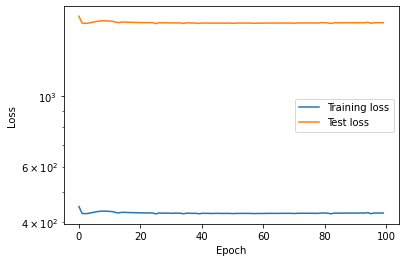

In [46]:
train_loss_1_1, test_loss_1_1 = trainer(trainset_net1, testset_net1, net1_alex_vide, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

In [47]:
# trainer(trainset_net1, testset_net1, net1_alex_vide, loss_fn = nn.MSELoss(), start_epoch=10, supp_epoch=10, batch_size=256, rate=1e-3, train_loss = train_loss, test_loss = test_loss, plot_perf = True)

In [48]:
# len(train_loss)

In [49]:
net1_alex_pretrained_continue = buildModel(convPart = "alexnet", FCsizes = [200,200,100], outputSize = 1, pretrained = True, stop_training = False)
#trainer(trainset_net1, testset_net1, net1_alex_pretrained_continue, loss_fn = nn.BCEWithLogitsLoss(), start_epoch=0, supp_epoch=10, batch_size=16, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

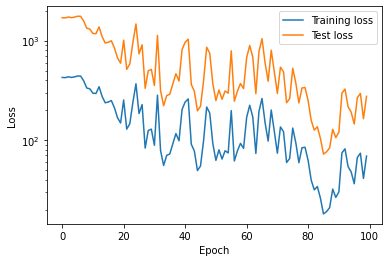

In [50]:
train, test = trainer(trainset_net1, testset_net1, net1_alex_pretrained_continue, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

In [51]:
#len(test)

In [52]:
#train, test = trainer(trainset_net1, testset_net1, net1_alex_pretrained_continue, loss_fn = nn.MSELoss(), start_epoch=10, supp_epoch=10, batch_size=256, rate=1e-3, train_loss = train, test_loss = test, plot_perf = True)

In [53]:
#len(train)

In [54]:
#train, test = trainer(trainset_net1, testset_net1, net1_alex_pretrained_continue, loss_fn = nn.MSELoss(), start_epoch=31, supp_epoch=169, batch_size=256, rate=1e-3, train_loss = train, test_loss = test, plot_perf = True)

In [55]:
net1_alex_pretrained_stop = buildModel(convPart = "alexnet", FCsizes = [200,200], outputSize = 1, pretrained = True, stop_training = True)

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

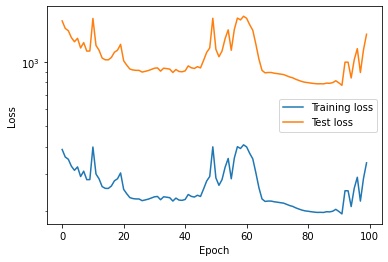

In [56]:
train, test = trainer(trainset_net1, testset_net1, net1_alex_pretrained_stop, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

In [57]:
net1_res_pretrained_continue = buildModel(convPart = "resnet18", FCsizes = [200,200], outputSize = 1, pretrained = True, stop_training = False)
#trainer(trainset_net1, testset_net1, net1_alex_vide, loss_fn = nn.BCEWithLogitsLoss(), start_epoch=0, supp_epoch=10, batch_size=16, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

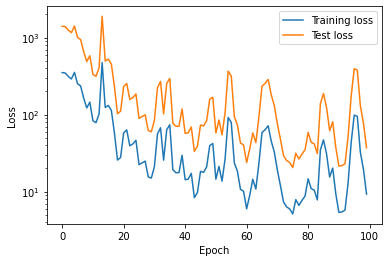

In [58]:
train, test = trainer(trainset_net1, testset_net1, net1_res_pretrained_continue, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

In [59]:
net1_res_pretrained_stop= buildModel(convPart = "resnet18", FCsizes = [200,200], outputSize = 1, pretrained = True, stop_training = True) 

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

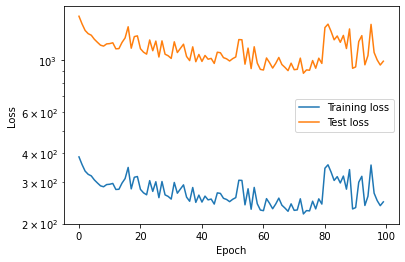

In [60]:
train, test = trainer(trainset_net1, testset_net1, net1_res_pretrained_stop, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

# Réseau 2 : prédiction de features + prédiction du score en fonction des features

## 2.a - Prédire les features

### Données pour 2.a

In [61]:
criterion_MSE = nn.MSELoss()
criterion_cross = nn.CrossEntropyLoss()
criterion_BCE = nn.BCEWithLogitsLoss()

In [62]:
# Données pour les 2 parties du réseau 2
Metadata_features = ["Subject Focus", "Eyes", "Face", "Near", "Action", "Accessory", "Group", 
                     "Collage", "Human", "Occlusion", "Info", "Blur"]


# Données de la partie a.) : Input image -> Output Metadata
input_a = x
output_a = list()

for i in range(len(dataset)):
    # Pour input
    #image = cv2.imread(dataset["Image_path"][i])
    #image_tensor = transform(image)
    #input_a.append(image_tensor)
    
    #image_flip = cv2.flip(image,1) # Flip verticalement
    #flip_tensor = transform(image_flip)
    #input_a.append(flip_tensor)
    
    # Pour output
    features = list()
    for f in Metadata_features:
        features.append(dataset[f][i])
    features_tensor = torch.tensor(features, dtype=torch.float)
    output_a.append(features_tensor)
    output_a.append(features_tensor)

# dataset_2a = list()
#for i in range(len(input_a)):
#    dataset_2a.append((input_a[i], output_a[i]))
dataset_2a = list(zip(input_a, output_a))

# Données divisées 4/5 (train) et 1/5 (test)
trainset_2a, testset_2a = train_test_split(dataset_2a, test_size = 3968.0/19824, shuffle = True)

In [63]:
print(trainset_2a[0][0])

tensor([[[ 0.2796,  0.3309,  0.3138,  ...,  2.2318,  2.2318,  2.2318],
         [ 0.3481,  0.4166,  0.3309,  ...,  2.2318,  2.2318,  2.2318],
         [ 0.2967,  0.3138,  0.3994,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-1.4329, -1.5014, -1.6384,  ..., -0.5938, -0.7137, -0.7993],
         [-1.4329, -1.5528, -1.6555,  ..., -0.5424, -0.6965, -0.7650],
         [-1.5699, -1.6727, -1.6213,  ..., -0.5424, -0.6965, -0.7993]],

        [[ 0.4853,  0.5028,  0.4678,  ...,  2.4111,  2.4111,  2.4111],
         [ 0.5728,  0.5903,  0.4853,  ...,  2.4111,  2.4111,  2.4111],
         [ 0.5028,  0.4853,  0.5553,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [-1.3354, -1.3704, -1.4580,  ..., -0.5126, -0.6176, -0.7227],
         [-1.3004, -1.4230, -1.4930,  ..., -0.4951, -0.5826, -0.6001],
         [-1.4055, -1.5105, -1.4930,  ..., -0.5126, -0.5651, -0.5826]],

        [[ 0.7228,  0.7228,  0.6705,  ...,  2.6226,  2.6226,  2.6226],
         [ 0.8099,  0.8099,  0.6879,  ...,  2

### Définitions des réseaux

In [64]:
net2a_res18_pretrained_continue = buildModel(convPart = "resnet18", FCsizes = [200,200,100], outputSize = 12, pretrained = True, stop_training = False)
summary(net2a_res18_pretrained_continue, (1,3,224,224))

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                        Output Shape              Param #
FactoryModel                                  --                        --
├─ResNet: 1-1                                 [1, 18432]                --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]          295,42

Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

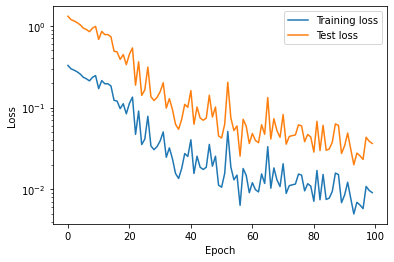

In [65]:
train_2a_res_continue, test_2a_res_continue = trainer(trainset_2a, testset_2a, net2a_res18_pretrained_continue, loss_fn = nn.BCEWithLogitsLoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=2e-3, train_loss = [], test_loss = [], plot_perf = True)

In [66]:
net2a_res18_pretrained_stop = buildModel(convPart = "resnet18", FCsizes = [200,200], outputSize = 12, pretrained = True, stop_training = True)

Using cache found in /home/petFinder/.cache/torch/hub/pytorch_vision_v0.10.0


Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

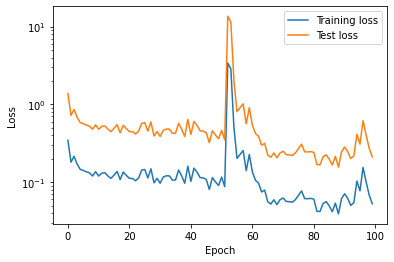

In [67]:
train_2a_res_stop, test_2a_res_stop = trainer(trainset_2a, testset_2a, net2a_res18_pretrained_stop, loss_fn = nn.BCEWithLogitsLoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=2e-3, train_loss = [], test_loss = [], plot_perf = True)

On constate que la vitesse d'entraînement est bien supérieure pour la version sans ré-entraînement du ResNet ("stop") : on passe de 24.5 s/it à 15 s/it !

Néanmoins, la version avec ré-entraînement semble bel et bien plus performante...

## 2.b - Prédire le score à partir des features

### Données pour 2.b

In [68]:
# Données de la partie b.) : Input Metadata -> Output Pawpularity
input_b = output_a.copy()
output_b = y.copy()

dataset_2b = list(zip(input_b, output_b))

# Données divisées 4/5 (train) et 1/5 (test)
trainset_2b, testset_2b = train_test_split(dataset_2b, test_size = 3968.0/19824, shuffle = True)

In [69]:
print(trainset_2b[0])

(tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([51.]))


### Définitions des réseaux

In [70]:
nb_features_b = 12
net2b_2x200 = FCModel(nb_features_b, [200,200])
summary(net2b_2x200, (1,nb_features_b))

Layer (type:depth-idx)                   Output Shape              Param #
FCModel                                  --                        --
├─Sequential: 1-1                        [1, 200]                  --
│    └─Linear: 2-1                       [1, 200]                  2,600
│    └─Linear: 2-2                       [1, 200]                  40,200
├─Linear: 1-2                            [1, 1]                    201
Total params: 43,001
Trainable params: 43,001
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.17
Estimated Total Size (MB): 0.18

Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

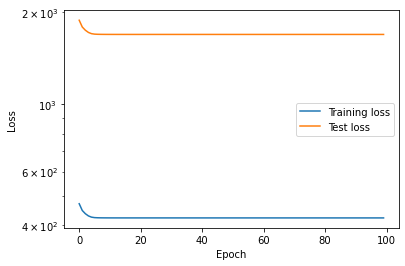

In [71]:
train_2b_1, test_2b_1 = trainer(trainset_2b, testset_2b, net2b_2x200, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

In [72]:
net2b_3x120 = FCModel(nb_features_b, [120,120,120])
summary(net2b_3x120, (1,nb_features_b))

Layer (type:depth-idx)                   Output Shape              Param #
FCModel                                  --                        --
├─Sequential: 1-1                        [1, 120]                  --
│    └─Linear: 2-1                       [1, 120]                  1,560
│    └─Linear: 2-2                       [1, 120]                  14,520
│    └─Linear: 2-3                       [1, 120]                  14,520
├─Linear: 1-2                            [1, 1]                    121
Total params: 30,721
Trainable params: 30,721
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.13

Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

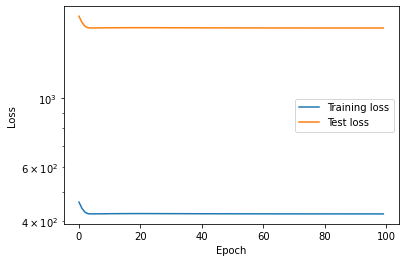

In [73]:
train_2b_2, test_2b_2 = trainer(trainset_2b, testset_2b, net2b_3x120, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

In [74]:
net2b_4x200 = FCModel(nb_features_b, [200,200,200,200])
summary(net2b_4x200, (1,nb_features_b))

Layer (type:depth-idx)                   Output Shape              Param #
FCModel                                  --                        --
├─Sequential: 1-1                        [1, 200]                  --
│    └─Linear: 2-1                       [1, 200]                  2,600
│    └─Linear: 2-2                       [1, 200]                  40,200
│    └─Linear: 2-3                       [1, 200]                  40,200
│    └─Linear: 2-4                       [1, 200]                  40,200
├─Linear: 1-2                            [1, 1]                    201
Total params: 123,401
Trainable params: 123,401
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.49
Estimated Total Size (MB): 0.50

Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

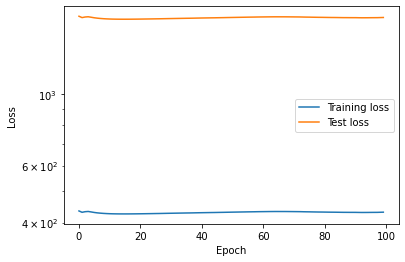

In [75]:
train_2b_3, test_2b_3 = trainer(trainset_2b, testset_2b, net2b_4x200, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

## 2.c - prédiction de bout en bout

In [76]:
class Model2(nn.Module):

    def __init__(self, _subModelA, _subModelB, _featuresList):
        """
        Prend en entrée le modèle 2.a et le modèle 2.b pour les faire fonctionner ensemble pour la prédiction et l'aide automatique à l'amélioration
        _featuresList est le tableau des noms des features dans l'ordre, de sorte que featuresList[i] est le nom de la feature d'indice i
        """
        super(Model2, self).__init__()
        self.subModelA = _subModelA
        self.subModelB = _subModelB
        self.featuresList = _featuresList
        self.cuda()
        self.advices = True
  
    def forward(self, x):
        with torch.no_grad():
            x = self.subModelA(x)
            x = nn.functional.sigmoid(x)
        x.requires_grad = True
        y = self.subModelB(x)
        if self.advices:
            y.backward()
            gradients_features = [(i, abs(x.grad[0,i])) for i in range(x.size(1))] # La fonctionnalité de recommandations suppose des batch_size de 1, autrement dit on soumet une image à la fois au système
            gradients_ordonnes = sorted(gradients_features, key = (lambda x : x[1]), reverse=True)
            print("Here is some advice to improve your photograph, by decreasing order of influence :")
        for i,a in gradients_ordonnes:
            if x.grad[0,i] > 0:
                advice_type = "Increase the criterion : "
            elif x.grad[0,i] < 0:
                advice_type = "Decrease the criterion : "
            else :
                advice_type = "This criterion won't change a lot the outcome : "
            print("\t{}{}".format(advice_type, self.featuresList[i]))
        return y

Une fois les deux parties du modèle 2 entraînées, pour l'utilisation, il faut que
```
model.advices = True
```
afin d'activer le moteur de recommandations (à base de gradients du score par rapport aux features)

In [77]:
net2 = Model2(net2a_res18_pretrained_continue, net2b_4x200, Metadata_features)

Voici un exemple de scoring et de recommandation associée

In [78]:
net2(input_a[0].cuda().view((1,3,224,224)))

Here is some advice to improve your photograph, by decreasing order of influence :
	Decrease the criterion : Blur
	Increase the criterion : Face
	Decrease the criterion : Eyes
	Increase the criterion : Action
	Increase the criterion : Group
	Increase the criterion : Accessory
	Increase the criterion : Occlusion
	Decrease the criterion : Subject Focus
	Increase the criterion : Near
	Increase the criterion : Info
	Decrease the criterion : Collage
	Decrease the criterion : Human


/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[35.0087]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Réseau 3 : prédiction de PawPularity par features + image réintroduite

Étant donné que l'on va utiliser 2 fois une analyse de l'image par des couches convolutives pré-entraînées, cela semblerait être un gaspillage de mémoire et de temps que de dédoubler ces couches CNN avec d'un côté l'intégralité du réseau 2.A et de l'autre de simples couches convolutives, dont le résultat serait fusionné avec celui de 2.A.

Ainsi, on va plutôt se servir de _ce que contient_ 2.A pour effectuer un seul passage par les couches convolutives puis utiliser ce résultat plusieurs fois.

In [122]:
class Model3(nn.Module):

    def __init__(self, _model2A, convOutputSize, _FCsizes = [1000, 1000], _hard_features = False, _outputSize = 1, _features_list = Metadata_features):
        """
        _model2A : modèle type 2.A (défini précédemment) prédisant les features des images, déjà entraîné, à réutiliser ici
        convOutputSize : taille de la sortie (vectorisée) de la partie convolutive
        _FCsizes : liste de couches entièrement connectées décrites par leurs nombres de composantes
        _hard_features : définit si on effectue une prédiction binaire dans la partie features, ou si l'on garde la sortie du réseau 2.A telle quelle
        _outputSize : taille de la sortie attendue
        """
        super(Model3, self).__init__()

        self.hard_features = _hard_features
    
        ## On intègre le modèle type 2.A et on le "fige" : il est supposé déjà entraîné (de toute façon on ne pourrait pas l'entraîner simultanément)
        self.model2A = _model2A
        for p in self.model2A.parameters():
            p.requires_grad = False
    
        in_features = convOutputSize + nb_features_b # on n'oublie pas de prendre en compte les features précédemment calculées
        FClist = []
        for n in _FCsizes:
            FClist.append(nn.Linear(in_features, n))
            in_features = n
        self.FCLayers = nn.Sequential(*FClist)
        self.finalLayer = nn.Linear(in_features, _outputSize)
        
        self.advices = False
        self.featuresList = _features_list
  
    def forward(self, x):
        with torch.no_grad():
            x = self.model2A.convLayers(x)
            
            y = self.model2A.FCLayers(x)
            y = self.model2A.finalLayer(y)
            # A ce stade, y est la sortie de model2A, autrement dit une représentation des 12 features (pas à l'échelle), et x est la sortie des couches convolutives

            if self.hard_features:
                y1 = torch.round(torch.sigmoid(y))
            else:
                y1 = y
    
        y1.requires_grad = True # Pour faire des recommandations, il faut "tracer" l'influence de y1 sur la suite des calculs

        z = torch.cat([y1, x], dim=1)

        z = self.FCLayers(z)
        z = self.finalLayer(z)

        if self.advices:
            z.backward()
            #print(y1.size(1))
            gradients_features = [(i, abs(y1.grad[0,i])) for i in range(y1.size(1))] # La fonctionnalité de recommandations suppose des batch_size de 1, autrement dit on soumet une image à la fois au système
            gradients_ordonnes = sorted(gradients_features, key = (lambda x : x[1]), reverse=True)
            #print(gradients_features)
            #print(gradients_ordonnes)
            print("Here is some advice to improve your photograph, by decreasing order of influence :")
            for i,a in gradients_ordonnes:
                if y1.grad[0,i] > 0:
                    advice_type = "Increase the criterion : "
                elif y1.grad[0,i] < 0:
                    advice_type = "Decrease the criterion : "
                else :
                    advice_type = "This criterion won't change a lot the outcome : "
                print("\t{}{}".format(advice_type, self.featuresList[i]))
            
        return z

In [89]:
def buildModel3(_model2A, _FCsizes = [1000, 1000], _hard_features = False, _outputSize = 1):
    """
    Construit un modèle type 3 à partir d'un modèle type 2.A construit via FactoryModel
    L'intérêt est que FactoryModel garde trace de la taille de sortie de sa partie convolutive dans self.convOutputSize
    """
    assert isinstance(_model2A, FactoryModel)
    return Model3(_model2A, _model2A.convOutputSize, _FCsizes, _hard_features, _outputSize)

In [129]:
net3_2x200p100_res18_pretrained_stop_softFeatures = buildModel3(net2a_res18_pretrained_continue, _FCsizes = [200,200,100], _hard_features = False)

In [82]:
net3_2x200p100_res18_pretrained_stop_hardFeatures = buildModel3(net2a_res18_pretrained_continue, _FCsizes = [200,200,100], _hard_features = True)

Epochs supplementaires:   0%|          | 0/5 [00:00<?, ?it/s]

Parcours des données:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure train loss:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure test loss:   0%|          | 0/16 [00:00<?, ?it/s]

Parcours des données:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure train loss:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure test loss:   0%|          | 0/16 [00:00<?, ?it/s]

Parcours des données:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure train loss:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure test loss:   0%|          | 0/16 [00:00<?, ?it/s]

Parcours des données:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure train loss:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure test loss:   0%|          | 0/16 [00:00<?, ?it/s]

Parcours des données:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure train loss:   0%|          | 0/62 [00:00<?, ?it/s]

Mesure test loss:   0%|          | 0/16 [00:00<?, ?it/s]

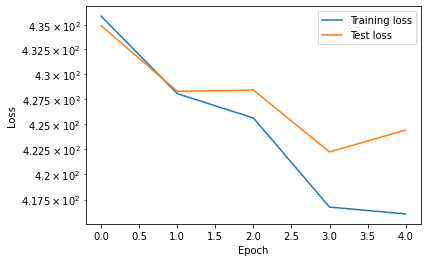

In [130]:
train_3_soft, test_3_soft = trainer(trainset_net1, testset_net1, net3_2x200p100_res18_pretrained_stop_softFeatures, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=5, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

Epochs supplementaires:   0%|          | 0/100 [00:00<?, ?it/s]

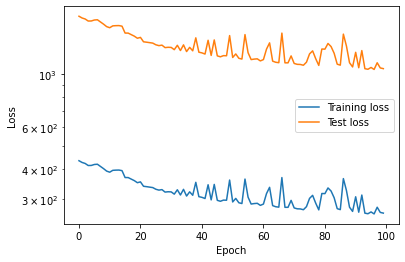

In [84]:
train_3_hard, test_3_hard = trainer(trainset_net1, testset_net1, net3_2x200p100_res18_pretrained_stop_hardFeatures, loss_fn = nn.MSELoss(), start_epoch=0, supp_epoch=100, batch_size=256, rate=1e-3, train_loss = [], test_loss = [], plot_perf = True)

In [131]:
# Seulement après l'entraînement :
net3_2x200p100_res18_pretrained_stop_softFeatures.advices = True

In [139]:
print(net3_2x200p100_res18_pretrained_stop_softFeatures(input_a[233].view((1,3,224,224)).cuda()))

Here is some advice to improve your photograph, by decreasing order of influence :
	Increase the criterion : Eyes
	Decrease the criterion : Blur
	Decrease the criterion : Group
	Increase the criterion : Face
	Increase the criterion : Near
	Decrease the criterion : Occlusion
	Decrease the criterion : Collage
	Decrease the criterion : Subject Focus
	Decrease the criterion : Info
	Decrease the criterion : Accessory
	Decrease the criterion : Human
	Increase the criterion : Action
tensor([[-26.2144]], device='cuda:0', grad_fn=<AddmmBackward0>)
